In [15]:
import numpy as np
import scipy.io
from numpy.random import multivariate_normal
from scipy.linalg import cho_factor, cho_solve

In [16]:
# Define vectores para los colores de la representación gráfica.
dark = np.array([51.0, 51.0, 51.0]) / 255.0
red = np.array([141.0, 45.0, 57.0]) / 255.0
gold = np.array([174.0, 159.0, 109.0]) / 255.0
gray = np.array([175.0, 179.0, 183.0]) / 255.0
lred = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - red)
lgold = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - gold)

Definimos las funciones asociadas a los
rasgos que metemos en la regresión. La más básica es la lineal.

In [ ]:
def phi(a):  # phi(a) = [1,a]
    # La función range crea una secuencia hasta el número inferior al que le pasemos. 
    return np.power(a, range(2))

Incluimos otras nuevas funciones un poco más exóticas.

In [33]:
def phi(a):
    # Función lineal a trozos. La función linspace crea un array de tamaño el último número
    # y elementos del primero al segundo de forma equiespaciada.
    return 1 * (np.abs(a - np.linspace(-8, 8, 8).T)) - np.linspace(-8, 8, 8)

In [70]:
def phi(a):
    # Función salto definida a trozos. En cada trozo te dice si a es mayor que el valor 
    # en ese intervalo o no. Se vale de que True=1, False=0.
    return 2 * (a > np.linspace(-8, 8, 8).T)  # steps that switch on


In [15]:
def phi(a):  # steps that change sign
    return 2 * ((a > np.linspace(-8, 8, 8).T) - 0.5)

In [8]:
def phi(a):
    # lineal
    return 1 * (np.abs(a - np.linspace(-8, 8, 8).T) - np.linspace(-8, 8, 8))

In [19]:
def phi(a):
    # ReLU: 
    F = 200
    return 1 * (a - np.linspace(-8.1, 8, F).T) * (a > np.linspace(-8.1, 8, F).T)

In [16]:
def phi(a):  # Fourier 
    return 3 * np.hstack((np.sin(a * np.arange(4)), np.cos(a * np.arange(4))))

In [25]:
def phi(a):
    return 5 * np.exp(
        -((a - np.linspace(-8, 8, 12).T) ** 2) / 2.0 / 0.5 ** 2
    )  # RBF 

In [77]:
def phi(a):  # "Eiffel"
    return 5 * np.exp(-np.abs(a - np.linspace(-8, 8, 12).T) / 1 ** 2)

Hacemos la regresión lineal paramétrica

In [18]:
#prior
F = len(phi(0))  # Numero de rasgos. Evaluado en 0 por poner algo que no sea dependiente.
# parametros de la a priori
mu = np.zeros((F, 1)) # F denota el número de filas, 1 de columnas
Sigma = np.eye(F)  # p(w)=N(mu,Sigma)
# a priori de f_x
n = 100  # puntos para el plot
x = np.linspace(-8, 8, n)[:, np.newaxis] 
m = phi(x) @ mu # Media para p(f)
kxx = phi(x) @ Sigma @ phi(x).T  # p(f_x)=N(m,kxx) 
s = multivariate_normal(m.flatten(), kxx + 1e-6 * np.eye(n), size=5).T
stdpi = np.sqrt(np.diag(kxx))[:, np.newaxis]  # desviacion estandar marginal

#data = scipy.io.loadmat("nlindata.mat")
#X = data["X"]  # inputs
#Y = data["Y"]  # outputs
X = np.array([-5,-3.4,-2,-1.4,3,4,5.6]).reshape(7,1)
Y = np.array([-2,3.4,0.3,1.4,-3,1,5]).reshape(7,1)


sigma=1.0 #ruido observaciones
N = len(X)  # numero observaciones
# evidencia: p(Y) = N(Y;M,kXX + sigma**2 * np.eye(N))
M = phi(X) @ mu
kXX = phi(X) @ Sigma @ phi(X).T  # p(f_X) = N(M,k_XX)
G = kXX + sigma ** 2 * np.eye(N)

# construimos la posteriori
# cholesky para evitar O(N^3)
G = cho_factor(G)
kxX = phi(x) @ Sigma @ phi(X).T  # Cov(f_x,f_X) = k_xX
A = cho_solve(G, kxX.T).T  

# posterior p(f_x|Y) = N(f_x,mpost,vpost)
mpost = m + A @ (Y - M)  # media
vpost = kxx - A @ kxX.T  # covarianza
spost = multivariate_normal(mpost.flatten(), vpost  + 1e-6 * np.eye(n), size=5).T  # muestras
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]  # desviacion estandar marginal

Hacemos las gráficas

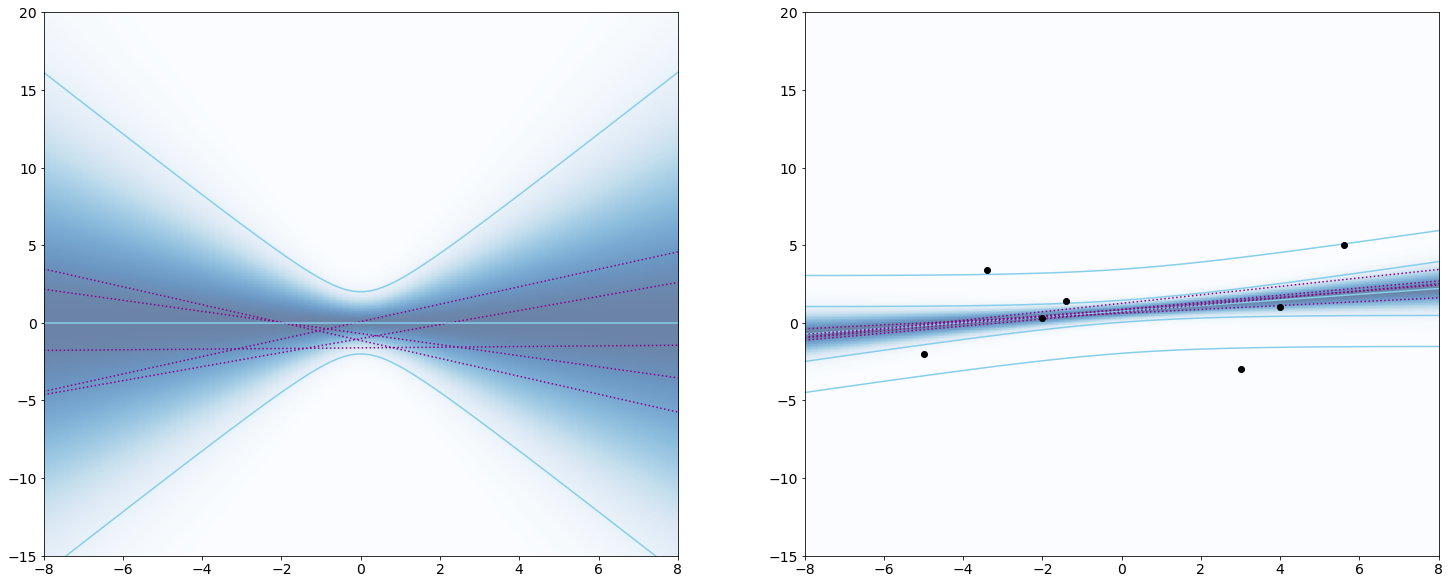

In [24]:
import matplotlib.pyplot as plt
from matplotlib import rc

plt.rcParams["figure.figsize"] = (25, 10)

rc('text', usetex=False)
rc('font', size=14)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('text.latex', preamble=r'\usepackage[sc]{mathpazo}')


fig, ax = plt.subplots(1, 2)

rc('font', size=14)
rc('legend', fontsize=13)



def GaussPDFscaled(y, m, s):  # sombreado
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)


yy = np.linspace(-15, 20, 200).reshape([200, 1])
P = GaussPDFscaled(yy, m, stdpi)


ax[0].imshow(
    P, extent=[-8, 8, -15, 20], aspect="auto", origin="lower", cmap="Blues", alpha=0.6
)
#ax[0].plot(x, phi(x), "-", color='skyblue')
ax[0].plot(x, s, ":", color='darkmagenta')  # prior
ax[0].plot(x, m, "-", color='skyblue')
ax[0].plot(x, m + 2 * stdpi, "-", color='skyblue')
ax[0].plot(x, m - 2 * stdpi, "-", color='skyblue')
ax[0].set(xlim=[-8, 8], ylim=[-15, 20], title="")


Ppost = GaussPDFscaled(yy, mpost, stdpo) 
ax[1].imshow(
    Ppost,
    extent=[-8, 8, -15, 20],
    aspect="auto",
    origin="lower",
    cmap="Blues",
    alpha=0.6,
)
ax[1].errorbar(X, Y, yerr=0, fmt='ok')
               #, capsize=4, capthick=1, markersize=4)  
ax[1].plot(x, mpost, "-", color='skyblue')  # media a posteriori
ax[1].plot(x, mpost + 2 * stdpo, "-", color='skyblue')  # barras error
ax[1].plot(x, mpost - 2 * stdpo, "-", color='skyblue')  # barras error

ax[1].plot(
    x, mpost + 2 * stdpo + 2 * sigma, "-", color='skyblue'
)  
ax[1].plot(x, mpost - 2 * stdpo - 2 * sigma, "-", color='skyblue')

ax[1].plot(x, spost, ":", color='darkmagenta')  # muestras
ax[1].set(xlim=[-8, 8], ylim=[-15, 20], title="", )

plt.show()